# Cálculo de Redes pelo Método Monte Carlo

## EXERCÍCIO 1

### FUNÇÕES DE GERAÇÃO DE REDES

Funções previamente utilizadas nos exercícios da Lista 2 para geração e resolução de redes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time as time

# Função para criar uma rede hidraulica com forma de grade quadrada
def GeraRede(nx,ny,CH,CV):
    nv = nx*ny
    nc = (nx-1)*ny + (ny-1)*nx
    
    coord = np.zeros(shape=(nv,2))

    for i in range(nx):
      for j in range(ny):
        ig = i + j*nx
        coord[ig,0] = i
        coord[ig,1] = j

    conec = np.zeros(shape=(nc,2), dtype=int)
    C = np.zeros(nc)
    
    # Loop sobre canos horizontais
    for j in range(ny):
        for i in range(nx-1):
          k = j*(nx-1) + i
          conec[k,0] = j*nx + i
          conec[k,1] = j*nx + i+1
          C[k] = CH

    # Loop sobre canos verticais
    for i in range(nx):
      for j in range(ny-1):
          k = (nx-1)*ny + j*nx + i
          conec[k,0] = i + j*nx
          conec[k,1] = i + (j+1)*nx
          C[k] = CV

    return nv, nc, conec, C, coord

def PlotPressure(m, n, pressure):
    x = np.arange(0, m, 1)
    y = np.arange(0, n, 1)
    X,Y=np.meshgrid(x,y)
    Z = np.copy(pressure)
    Z.shape = (n,m)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_aspect('equal')
    ax.set(xlabel='x', ylabel='y', title='Contours of pressure')
    ax.grid()
    ax.set_xticks(x)
    ax.set_yticks(y)
    cp = plt.contourf(X, Y, Z, cmap='jet')
    cb = plt.colorbar(cp)
    plt.show()

def PlotPressureAsSurface(m, n, pressure):
    x = np.arange(0, m, 1)
    y = np.arange(0, n, 1)
    X,Y=np.meshgrid(x,y)
    Z = np.copy(pressure)
    Z.shape = (n,m)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_aspect('equal')
    ax.set(xlabel='x', ylabel='y', title='Contours of pressure')
    ax.grid()
    ax.set_xticks(x)
    ax.set_yticks(y)
    ax = plt.axes(projection="3d")
    ax.plot_surface(X, Y, Z, cmap='jet', edgecolor=None)
    ax.set(xlabel='$x$', ylabel='$y$', zlabel='$z$')
    ax.view_init(elev=30., azim=45)
    plt.show()

In [2]:
def Assembly(conec, C,nc,nv):
    
    #cria a matriz base do sistema
    A = np.zeros(shape=(nv,nv))

    for k in range(nc):
        i1=(conec[k][0])
        i2=(conec[k][1])
        
        A[i1][i1] += C[k]
        A[i2][i2] += C[k]
        
        A[i2][i1] = -C[k]
        A[i1][i2] = -C[k]
        
    return A

def SolveNetwork(conec,C, natm, nB, QB,nc,nv):
    
    Atilde=Assembly(conec,C,nc,nv)

    for k in range(nv):
        if k==natm :
            Atilde[natm][natm] = 1
        else:
            Atilde[natm][k]=0

    b = np.zeros(shape=(nv,1))
    b[nB]=QB
    
    pressure = np.linalg.solve(Atilde, b)
    return pressure

def SolveQ (conec,C,P,nc,nv):
    
    K=np.zeros(shape=(nc,nc))
    for j in range(nc):
        K[j][j]=C[j]    
    
    D=np.zeros(shape=(nc,nv))
    for k in range(nc):
        for j in range(nv):
            if j==conec[k][0]-1:
                D[k][j]=1
            elif j==conec[k][1]-1:
                D[k][j]=-1
    
    return ((K@D)@P)

In [3]:
CH = 1.3
CV = 3.6
m, n = 10, 12
nv, nc, conec, C, coord = GeraRede(m, n , CH, CV)
natm=nv-1
nB=0
QB=3

P = SolveNetwork(conec,C,natm,nB,QB,nc,nv)

### GERAÇÃO DE REDES OBSTRUIDAS

In [4]:
#Po=[0.01,0.03,0.05,0.1,0.2,0.25,0.3,0.4] #probabilidades de ocorrência de obstrução de um cano

def GeraRedeObstruida(m, n , CH, CV, QB, nB, Po,Reduction):
    
    nv, nc, conec, C, coord = GeraRede(m, n , CH, CV)               # Gera a rede que vai ser obstruida
    natm=nv-1

    OldPressure=SolveNetwork(conec,C,natm,nB,QB,nc,nv)              # Pressão gerada pela rede inicial sem obstrução

    NC=C

    for i in range(nc):                                             # Loop para alteração das condutancias dos canos

        prob=np.random.rand()                                       # Probabilidade de que ocorra obstrução no cano i
        
        if prob<=Po:                                                # Caso ocorra obstrucao
            NC[i] = NC[i]*(1-Reduction)                             # Redução da condutancia do cano selecionado

    NewPressure = SolveNetwork(conec,NC,natm,nB,QB,nc,nv)           # Nova Pressões geradas com novas condutãncias
    
    return NewPressure

In [5]:
CH = 1.3                    # Condutancia horizontal
CV = 3.6                    # Condutancia vertical
m, n = 10, 12               # Tamanho da rede
nB=0                        # Cano da vazao de entrada
QB=10                       # Vazao de entrada

Po=0.1                      # Probabilidade de obstrucao
Reduction=0.935             # Porcentagem de redução da condutância do cano caso obstruido

NewPressure = GeraRedeObstruida(m, n , CH, CV,QB,nB, Po, Reduction)


## EXERCÍCIO 2

In [6]:
def MonteCarlo(Prob,Testes):
    Probab=[]

    CH = 1.3                    # Condutancia horizontal
    CV = 3.6                    # Condutancia vertical
    m, n = 10, 12               # Tamanho da rede
    nB=0
    QB=3

    Reduction=0.935             # Porcentagem de redução da condutância do cano caso obstruido
    nv, nc, conec, C, coord = GeraRede(m, n , CH, CV)

    flag=0
    for j in range(Testes):
        NP = GeraRedeObstruida(m, n , CH, CV,QB,nB, Prob, Reduction)
        if np.max(NP)>=12:
            flag+=1
        Probab.append((flag/(j+1))*100)

    return Probab


In [7]:
Testes=10000
Nrep=[]

for i in range(Testes):
    Nrep.append(i+1)

Probab0 = MonteCarlo(0.03,Testes)
Probab1 = MonteCarlo(0.05,Testes)
Probab2 = MonteCarlo(0.10,Testes)
Probab3 = MonteCarlo(0.15,Testes)
Probab4 = MonteCarlo(0.20,Testes)
Probab5 = MonteCarlo(0.25,Testes)
Probab6 = MonteCarlo(0.30,Testes)
Probab7 = MonteCarlo(0.35,Testes)
Probab8 = MonteCarlo(0.40,Testes)
Probab9 = MonteCarlo(0.45,Testes)
Probab10= MonteCarlo(0.47,Testes)
Probab11= MonteCarlo(0.50,Testes)
Po=[0.03,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.47,0.50]

#Célula demora em média 3,5min para ser totalmente executada


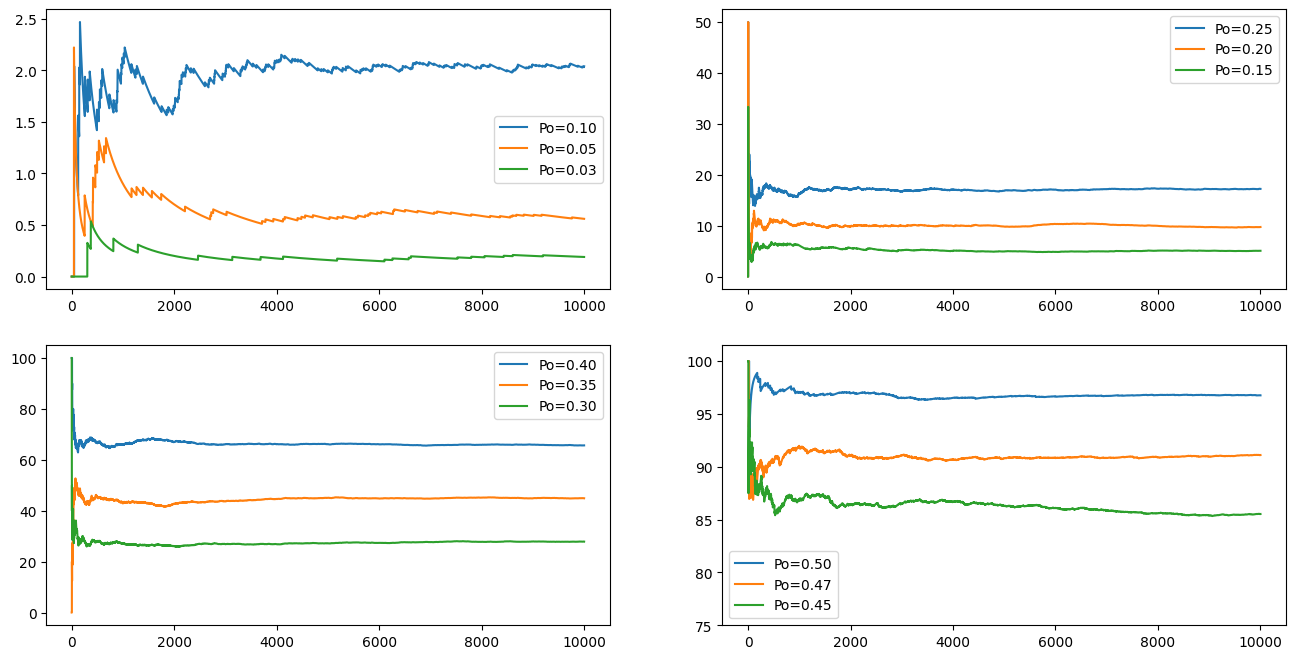

In [8]:
figure, graphs = plt.subplots(2, 2, figsize=(16, 8))

graphs[0,0].plot(Nrep,Probab2)
graphs[0,0].plot(Nrep,Probab1)
graphs[0,0].plot(Nrep,Probab0)
graphs[0,0].legend(['Po=0.10','Po=0.05','Po=0.03'])

graphs[0,1].plot(Nrep,Probab5)
graphs[0,1].plot(Nrep,Probab4)
graphs[0,1].plot(Nrep,Probab3)
graphs[0,1].legend(['Po=0.25','Po=0.20','Po=0.15'])

graphs[1,0].plot(Nrep,Probab8)
graphs[1,0].plot(Nrep,Probab7)
graphs[1,0].plot(Nrep,Probab6)
graphs[1,0].legend(['Po=0.40','Po=0.35','Po=0.30'])


graphs[1,1].set_ylim(75,101.5)
graphs[1,1].plot(Nrep,Probab11)
graphs[1,1].plot(Nrep,Probab10)
graphs[1,1].plot(Nrep,Probab9)
graphs[1,1].legend(['Po=0.50','Po=0.47','Po=0.45'])

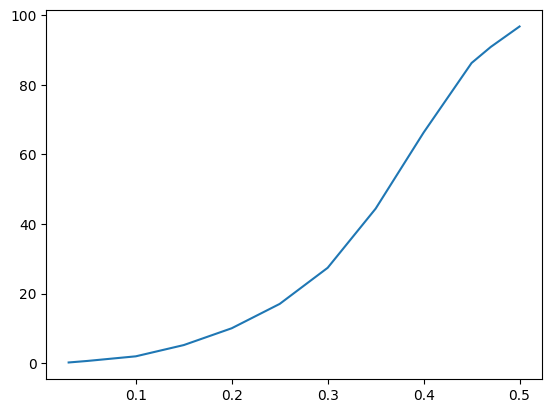

In [9]:
HighPressure=[np.average(Probab0),np.average(Probab1),np.average(Probab2),np.average(Probab3),np.average(Probab4),np.average(Probab5),
              np.average(Probab6),np.average(Probab7),np.average(Probab8),np.average(Probab9),np.average(Probab10),np.average(Probab11)]

plt.plot(Po,HighPressure)

(65.0, 101.5)

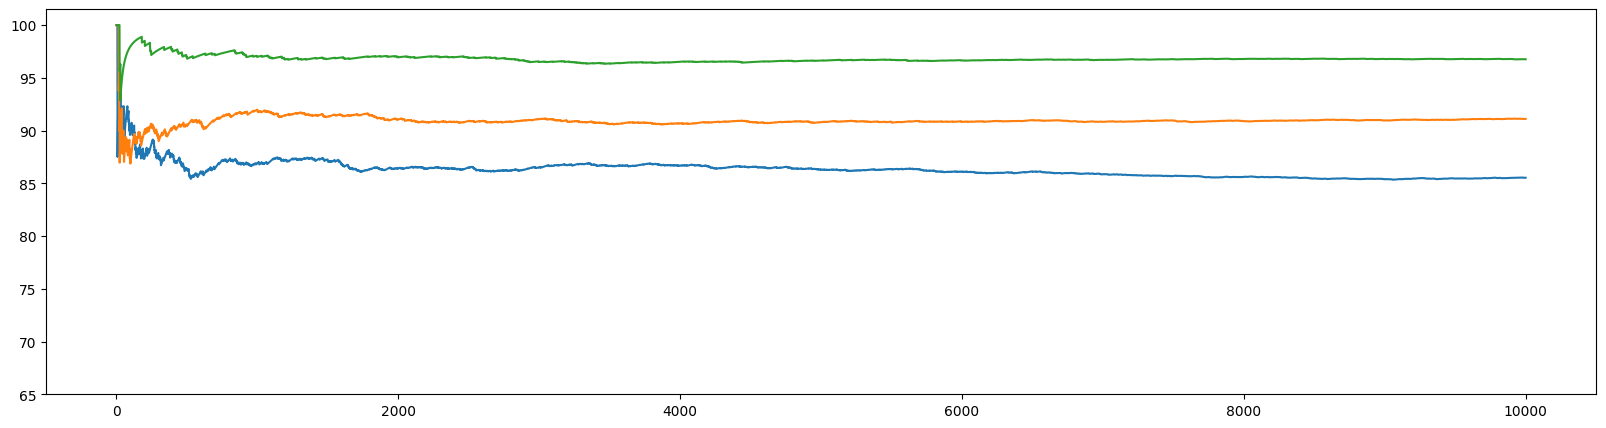

In [10]:

plt.figure(figsize=(20, 5))
plt.plot(Nrep,Probab9)
plt.plot(Nrep,Probab10)
plt.plot(Nrep,Probab11)
plt.ylim(ymin=65,ymax=101.5)